In [54]:
import pandas as pd
import regex as re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
%matplotlib inline

<h1>Read Datasets</h1>

In [2]:
df = pd.read_csv('IMDB Dataset.csv')
df = df[:3000]

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     3000 non-null   object
 1   sentiment  3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<h1>Data Preprocessing</h1>

<h2>Case Folding</h2>

In [3]:
def case_folding(text):
    text = text.lower()

    return text

In [4]:
df['review'] = df['review'].apply(case_folding)

In [5]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


<h2>Remove HTML Encoding & Punctuations</h2>

In [6]:
df['html_tag'] = df['review'].apply(lambda x: re.findall(r'\W', x))
df['html_tag'] = df['html_tag'].apply(''.join)

df['html_tag'].head()

0                  '  .   ,        .< />< />       ...
1       . < />< />     -  --     ,   ,       . < />...
2                   ,          - .    ,           (...
3     '       ()  '      &       .< />< />       .....
4     ' "     "       . .         .            ,   ...
Name: html_tag, dtype: object

In [7]:
def remove_punctuations_and_html_encoding(text):
    patterns = '[^\w\s]'
    patterns2 = 'br'

    text = re.sub(patterns, '', text)
    text = re.sub(patterns2, '', text)

    return text

In [8]:
df['review'] = df['review'].apply(remove_punctuations_and_html_encoding)

In [9]:
df['html_tag_after'] = df['review'].apply(lambda x: re.findall(r'\W', x))

In [10]:
df.head()

,review,sentiment,html_tag,html_tag_after
0,one of the other reviewers has mentioned that ...,positive,"' . , .< />< /> ...","[ , , , , , , , , , , , , , , , ..."
1,a wonderful little production the filming te...,positive,". < />< /> - -- , , . < />...","[ , , , , , , , , , , , , , , , ..."
2,i thought this was a wonderful way to spend ti...,positive,", - . , (...","[ , , , , , , , , , , , , , , , ..."
3,basically theres a family where a little boy j...,negative,' () ' & .< />< /> .....,"[ , , , , , , , , , , , , , , , ..."
4,petter matteis love in the time of money is a ...,positive,"' "" "" . . . , ...","[ , , , , , , , , , , , , , , , ..."


<h2>Stopwords Removal</h2>

In [11]:
from nltk.corpus import stopwords
import nltk

In [12]:
def stopword_removal(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.casefold() not in stop_words]

    return ' '.join(filtered_words)

In [13]:
df['review'] = df['review'].apply(stopword_removal)

df.head()

,review,sentiment,html_tag,html_tag_after
0,one reviewers mentioned watching 1 oz episode ...,positive,"' . , .< />< /> ...","[ , , , , , , , , , , , , , , , ..."
1,wonderful little production filming technique ...,positive,". < />< /> - -- , , . < />...","[ , , , , , , , , , , , , , , , ..."
2,thought wonderful way spend time hot summer we...,positive,", - . , (...","[ , , , , , , , , , , , , , , , ..."
3,basically theres family little boy jake thinks...,negative,' () ' & .< />< /> .....,"[ , , , , , , , , , , , , , , , ..."
4,petter matteis love time money visually stunni...,positive,"' "" "" . . . , ...","[ , , , , , , , , , , , , , , , ..."


In [14]:
df = df.drop(columns=['html_tag', 'html_tag_after'])

df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


In [15]:
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})

df

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1
...,...,...
2995,experience head really need understand monkees...,1
2996,im fan judy garland vincente minnelli gene kel...,0
2997,mr harvey lights candle anchored illiant perfo...,1
2998,della myers kim basinger upperclass housewife ...,0


<h2>Train Test Split</h2>

In [16]:
X = df['review'].values
y = df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
print(f'Length Train Set: {len(X_train)}\n')
print(f'Length Test Set: {len(X_test)}\n')

Length Train Set: 2400

Length Test Set: 600



In [18]:
X_train[0]

'amazed reviews film place seems tell truth rottentomatoescom film awful plot extremely lazy scary either people think stars sarah michelle geller somehow like grudge forget film like dark water except even predictable slow moving extremely disappointed film didnt scare interest either lets face type plot flogged death stage eg dead trying contact living dragonfly lies beneath ghost story dark water darkness changeling etcetc seems ones writing original horror films nowadays japanese koreans films coming hollywood like cynical exercises money making without shred respect viewer theyre churned'

<h1>Naive Bayes Algorithm</h1>

<h2>Term Frequency</h2>

In [19]:
word2id = {}
counter = 0

for sentence in X_train:
    tokens = sentence.split()
    for token in tokens:
        if token not in word2id:
            word2id[token] = counter
            counter += 1

In [20]:
word2id

{'amazed': 0,
 'reviews': 1,
 'film': 2,
 'place': 3,
 'seems': 4,
 'tell': 5,
 'truth': 6,
 'rottentomatoescom': 7,
 'awful': 8,
 'plot': 9,
 'extremely': 10,
 'lazy': 11,
 'scary': 12,
 'either': 13,
 'people': 14,
 'think': 15,
 'stars': 16,
 'sarah': 17,
 'michelle': 18,
 'geller': 19,
 'somehow': 20,
 'like': 21,
 'grudge': 22,
 'forget': 23,
 'dark': 24,
 'water': 25,
 'except': 26,
 'even': 27,
 'predictable': 28,
 'slow': 29,
 'moving': 30,
 'disappointed': 31,
 'didnt': 32,
 'scare': 33,
 'interest': 34,
 'lets': 35,
 'face': 36,
 'type': 37,
 'flogged': 38,
 'death': 39,
 'stage': 40,
 'eg': 41,
 'dead': 42,
 'trying': 43,
 'contact': 44,
 'living': 45,
 'dragonfly': 46,
 'lies': 47,
 'beneath': 48,
 'ghost': 49,
 'story': 50,
 'darkness': 51,
 'changeling': 52,
 'etcetc': 53,
 'ones': 54,
 'writing': 55,
 'original': 56,
 'horror': 57,
 'films': 58,
 'nowadays': 59,
 'japanese': 60,
 'koreans': 61,
 'coming': 62,
 'hollywood': 63,
 'cynical': 64,
 'exercises': 65,
 'money': 

In [21]:
X_vec_matrix = np.zeros((len(X_train), len(word2id)))

In [22]:
for index_sen, sentences in enumerate(X_train):
    for term, index_term in word2id.items():
        if term in sentences:
            X_vec_matrix[index_sen][index_term] += 1

In [23]:
X_vec_matrix = X_vec_matrix.astype(int)

In [24]:
X_vec_matrix

array([[1, 1, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

<h2>SMOTE</h2>

In [25]:
smote = SMOTE()

X_oversampled, y_oversampled = smote.fit_resample(X_vec_matrix, y_train)

<h3>Result</h3>

In [59]:
unique, counts = np.unique(y_oversampled, return_counts=True)

n_X_oversampled = counts[0]
n_y_oversampled = counts[1]

print(f'{n_X_oversampled}\n')
print(n_X_oversampled)

1224

1224


In [61]:
unique_b, counts_b = np.unique(y_train, return_counts=True)

n_X = counts_b[0]
n_y = counts_b[1]

print(f'{n_X}\n')
print(n_y)

1176

1224


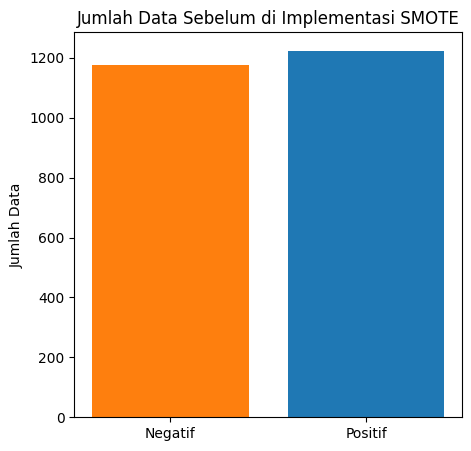

In [78]:
label = ['Negatif', 'Positif']
data = [n_X, n_y]

plt.figure(figsize=(5,5))
plt.title('Jumlah Data Sebelum di Implementasi SMOTE')
plt.bar(label, data, color=['#FE7F0E','#1F78B4']) 
plt.ylabel('Jumlah Data')

plt.show()

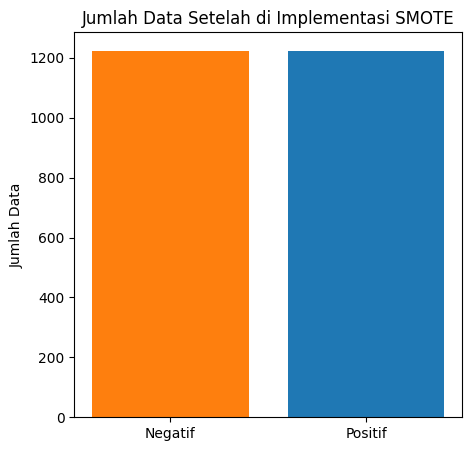

In [77]:
label_oversampled = ['Negatif', 'Positif']
data_oversampled = [n_X_oversampled, n_y_oversampled]

plt.figure(figsize=(5,5))
plt.title('Jumlah Data Setelah di Implementasi SMOTE')
plt.bar(label_oversampled, data_oversampled, color=['#FE7F0E','#1F78B4']) 
plt.ylabel('Jumlah Data')

plt.show()

In [34]:
word2count = {}
counter = 0
vocab = list(word2id.keys())

for l in range(2):
    word2count[l] = defaultdict(lambda: 0)
for i in range(X_oversampled.shape[0]):
    l = y_oversampled[i]
    for j in range(len(word2id)):
        word2count[l][vocab[j]] += X_oversampled[i][j]

In [35]:
word2count

{0: defaultdict(<function __main__.<lambda>()>,
             {'amazed': 5,
              'reviews': 41,
              'film': 729,
              'place': 134,
              'seems': 155,
              'tell': 183,
              'truth': 38,
              'rottentomatoescom': 1,
              'awful': 135,
              'plot': 332,
              'extremely': 50,
              'lazy': 8,
              'scary': 47,
              'either': 124,
              'people': 302,
              'think': 317,
              'stars': 65,
              'sarah': 5,
              'michelle': 3,
              'geller': 2,
              'somehow': 40,
              'like': 650,
              'grudge': 8,
              'forget': 44,
              'dark': 59,
              'water': 34,
              'except': 85,
              'even': 561,
              'predictable': 58,
              'slow': 77,
              'moving': 32,
              'disappointed': 67,
              'didnt': 210,
              'scare

<h2>Laplace Smoothing</h2>

In [36]:
def laplace_smoothing(n_label_items, vocab, word_counts, word, text_label):
    a = word_counts[text_label][word] + 1
    b = n_label_items[text_label] + len(vocab)
    return np.log10(a/b)

<h2>Group Data by Label</h2>

In [37]:
def group_by_label(x, y, labels):
    data = {}
    for l in labels:
        data[l] = x[np.where(y == l)]
    return data

<h2>Train Data</h2>

In [38]:
def fit(x, y, labels):
    n_label_items = {}
    log_label_priors = {}
    n = len(x)
    grouped_data = group_by_label(x, y, labels)
    for l, data in grouped_data.items():
        n_label_items[l] = len(data)
        log_label_priors[l] = np.log10(n_label_items[l] / n)
    
    return n_label_items, log_label_priors

<h2>Predict</h2>

In [39]:
def predict(n_label_items, vocab, word_counts, log_label_priors, labels, x):
    result = []
    for text in x:
        label_scores = {l: log_label_priors[l] for l in labels}
        words = text.split()
        for word in words:
            if word not in vocab: continue
            for l in labels:
                log_w_given_l = laplace_smoothing(n_label_items, vocab, word_counts, word, l)
                label_scores[l] += log_w_given_l
        result.append(max(label_scores, key=label_scores.get))
    
    return result

<h2>Testing</h2>

In [52]:
labels = [0,1]
n_label_items, log_label_priors = fit(X_oversampled,y_oversampled,labels)
pred = predict(n_label_items, vocab, word2count, log_label_priors, labels, X_test)

print(f'Accuracy of prediction on test set : {round(accuracy_score(y_test,pred), 3) * 100}%')

Accuracy of prediction on test set : 80.2%


In [53]:
print(f'Jumlah Prediksi Negative: {pred.count(0)}\n')
print(f'Jumlah Prediksi Positive: {pred.count(1)}\n')

Jumlah Prediksi Negative: 247

Jumlah Prediksi Positive: 353

